## Reproduce DARTFISH results with Starfish

DARTFISH is a multiplexed image based transcriptomics assay from the [Zhang lab](http://genome-tech.ucsd.edu/ZhangLab/). As of this writing, this assay is not published yet. Nevertheless, here we demonstrate that Starfish can be used to process the data from raw images into spatially resolved gene expression profiles

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from starfish import display
from starfish import data, FieldOfView
from starfish.types import Features, Axes

from starfish import IntensityTable

from starfish.image import Filter
from starfish.spots import DetectPixels

## Load data into Starfish from the Cloud

The example data here corresopond to DARTFISHv1 2017. The group is actively working on improving the protocol. The data represent human brain tissue from the human occipital cortex from 1 field of view (FOV) of larger experiment. The data from one field of view correspond to 18 images from 6 imaging rounds (r) 3 color channels (c) and 1 z-plane (z). Each image is 988x988 (y,x)

In [2]:
use_test_data = os.getenv("USE_TEST_DATA") is not None
experiment = data.DARTFISH(use_test_data=use_test_data)

imgs = experiment.fov().get_image(FieldOfView.PRIMARY_IMAGES)

print(imgs)

100%|██████████| 18/18 [00:24<00:00,  1.51s/it]

<starfish.ImageStack (r: 6, c: 3, z: 1, y: 988, x: 988)>


## Visualize codebook

The DARTFISH codebook maps pixel intensities across the rounds and channels to the corresponding barcodes and genes that those pixels code for. For this example dataset, the codebook specifies 96 possible barcodes. The codebook used in this experiment has 3 color channels and one blank channel, each of which contribute to codes. The presence of the blank channel will be important later when the filtering is described.

In [3]:
experiment.codebook

<xarray.Codebook (target: 96, c: 3, r: 6)>
array([[[0, 1, ..., 0, 0],
        [0, 0, ..., 1, 0],
        [1, 0, ..., 0, 0]],

       [[0, 1, ..., 1, 0],
        [1, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       ...,

       [[0, 0, ..., 0, 0],
        [0, 1, ..., 1, 0],
        [1, 0, ..., 0, 0]],

       [[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 1],
        [1, 1, ..., 0, 0]]], dtype=uint8)
Coordinates:
  * target   (target) object 'MYH11' 'RELN' 'NR4A2' ... 'GLRA2' 'MN1'
  * c        (c) int64 0 1 2
  * r        (r) int64 0 1 2 3 4 5

## Visualize raw data

A nice way to page through all this data is to use the display command. We have commented this out for now, because it will not render in Github. Instead, we simply show an image from the first round and color channel.

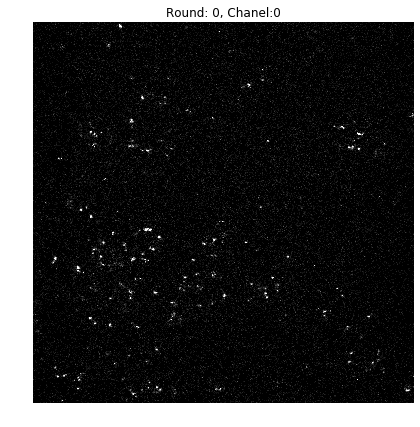

In [4]:
# %gui qt5
# display(stack)

single_plane = imgs.sel({Axes.ROUND: 0, Axes.CH: 0, Axes.ZPLANE: 0})
single_plane = single_plane.xarray.squeeze()
plt.figure(figsize=(7,7))
plt.imshow(single_plane, cmap='gray', clim=list(np.percentile(single_plane, [1, 99.9])))
plt.title('Round: 0, Chanel:0')
plt.axis('off');

## Filter and scale raw data before decoding into spatially resolved gene expression

First, we equalize the intensity of the images by scaling each image by its maximum intensity, which is equivalent to scaling by the 100th percentile value of the pixel values in each image.

In [5]:
sc_filt = Filter.Clip(p_max=100, expand_dynamic_range=True)
norm_imgs = sc_filt.run(imgs)

Next, for each imaging round, and each pixel location, we zero the intensity values across all three color channels if the magnitude of this 3 vector is below a threshold. As such, the code value associated with these pixels will be the blank. This is necessary to support euclidean decoding for codebooks that include blank values.

In [6]:
z_filt = Filter.ZeroByChannelMagnitude(thresh=.05, normalize=False)
filtered_imgs = z_filt.run(norm_imgs)

## Decode the processed data into spatially resolved gene expression profiles

Here, starfish decodes each pixel value, across all rounds and channels, into the corresponding target (gene) it corresponds too. Contiguous pixels that map to the same target gene are called as one RNA molecule. Intuitively, pixel vectors are matched to the codebook by computing the euclidean distance between the pixel vector and all codewords. The minimal distance gene target is then selected, if it is within `distance_threshold` of any code.

This decoding operation requires some parameter tuning, which is described below. First, we look at a distribution of pixel vector barcode magnitudes to determine the minimum magnitude threshold at which we will attempt to decode the pixel vector.

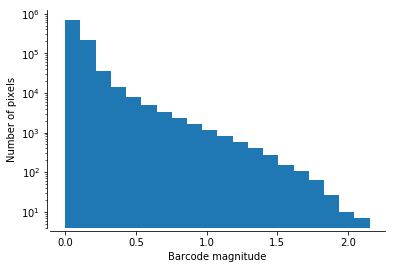

In [7]:
def compute_magnitudes(stack, norm_order=2):

    pixel_intensities = IntensityTable.from_image_stack(stack)
    feature_traces = pixel_intensities.stack(traces=(Axes.CH.value, Axes.ROUND.value))
    norm = np.linalg.norm(feature_traces.values, ord=norm_order, axis=1)

    return norm

mags = compute_magnitudes(filtered_imgs)

plt.hist(mags, bins=20);
sns.despine(offset=3)
plt.xlabel('Barcode magnitude')
plt.ylabel('Number of pixels')
plt.yscale('log');

Next, we decode the the data

In [8]:
# how much magnitude should a barcode have for it to be considered by decoding? this was set by looking at
# the plot above
magnitude_threshold = 0.5
# how big do we expect our spots to me, min/max size. this was set to be equivalent to the parameters
# determined by the Zhang lab.
area_threshold = (5, 30)
# how close, in euclidean space, should the pixel barcode be to the nearest barcode it was called to?
# here, I set this to be a large number, so I can inspect the distribution of decoded distances below
distance_threshold = 3

psd = DetectPixels.PixelSpotDecoder(
    codebook=experiment.codebook,
    metric='euclidean',
    distance_threshold=distance_threshold,
    magnitude_threshold=magnitude_threshold,
    min_area=area_threshold[0],
    max_area=area_threshold[1]
)

initial_spot_intensities, results = psd.run(filtered_imgs)

100%|██████████| 5289/5289 [00:02<00:00, 1834.42it/s]


In [9]:
spots_df = initial_spot_intensities.to_features_dataframe()
spots_df['area'] = np.pi*spots_df['radius']**2
spots_df = spots_df.loc[spots_df[Features.PASSES_THRESHOLDS]]
spots_df.head()

,radius,target,x,y,z,distance,passes_thresholds,features,xc,yc,zc,area
2,1.954410,EXPH5,954,0,0,0.645943,True,2,0.000967,0.000000,0.0005,12.0
5,1.954410,RNF152,928,3,0,0.458121,True,5,0.000940,0.000003,0.0005,12.0
7,1.954410,PLD4,295,5,0,0.540604,True,7,0.000299,0.000005,0.0005,12.0
11,2.034214,CTSS,225,7,0,0.727112,True,11,0.000228,0.000007,0.0005,13.0
12,2.185097,PCP4,383,7,0,0.523660,True,12,0.000388,0.000007,0.0005,15.0


## Compare to benchmark results

The below plot aggregates gene copy number across cells in the field of view and compares the results to the same copy numbers from the authors' pipeline. This can likely be improved by tweaking parameters in the above algorithms.

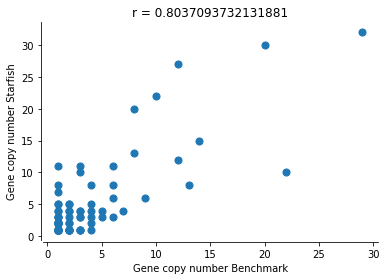

In [10]:
# load results from authors' pipeline
cnts_benchmark = pd.read_csv('https://d2nhj9g34unfro.cloudfront.net/20181005/DARTFISH/fov_001/counts.csv')
cnts_benchmark.head()

# select spots with distance less than a threshold, and count the number of each target gene
min_dist = 0.6
cnts_starfish = spots_df[spots_df.distance<=min_dist].groupby('target').count()['area']
cnts_starfish = cnts_starfish.reset_index(level=0)
cnts_starfish.rename(columns = {'target':'gene', 'area':'cnt_starfish'}, inplace=True)

benchmark_comparison = pd.merge(cnts_benchmark, cnts_starfish, on='gene', how='left')
benchmark_comparison.head(20)

x = benchmark_comparison.dropna().cnt.values
y = benchmark_comparison.dropna().cnt_starfish.values
r = np.corrcoef(x, y)
r = r[0,1]

plt.scatter(x, y, 50,zorder=2)

plt.xlabel('Gene copy number Benchmark')
plt.ylabel('Gene copy number Starfish')
plt.title('r = {}'.format(r))

sns.despine(offset=2)

## Visualize results

This image applies a pseudo-color to each gene channel to visualize the position and size of all called spots in the test image

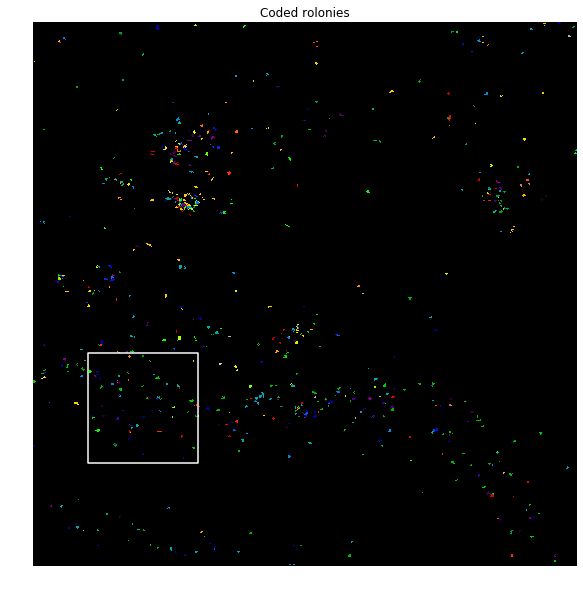

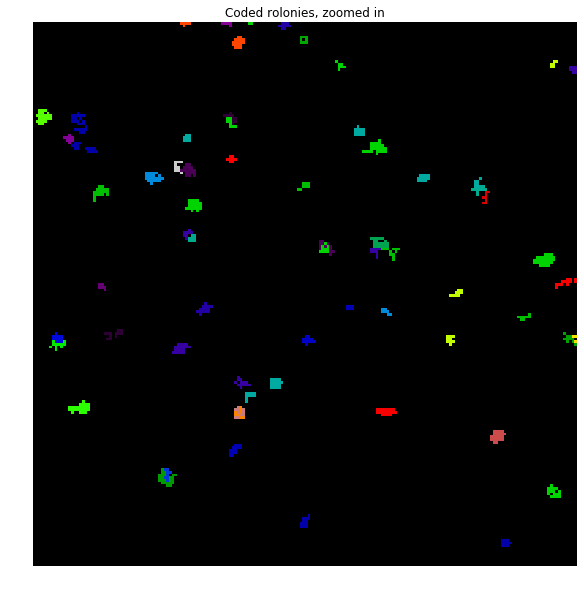

In [11]:
# exclude spots that don't meet our area thresholds
area_lookup = lambda x: 0 if x == 0 else results.region_properties[x - 1].area
vfunc = np.vectorize(area_lookup)
mask = np.squeeze(vfunc(results.label_image))
new_image = np.squeeze(results.decoded_image)*(mask > area_threshold[0])*(mask < area_threshold[1])

plt.figure(figsize=(10,10))
plt.imshow(new_image, cmap = 'nipy_spectral');
plt.axis('off');
plt.title('Coded rolonies');

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

rect = [Rectangle((100, 600), width=200, height=200)]
pc = PatchCollection(rect, facecolor='none', alpha=1.0, edgecolor='w', linewidth=1.5)
plt.gca().add_collection(pc)

plt.figure(figsize=(10,10))
plt.imshow(new_image[600:800, 100:300], cmap = 'nipy_spectral');
plt.axis('off');
plt.title('Coded rolonies, zoomed in');

## Parameter and QC analysis

Here, we further investigate reasonable choices for each of the parameters used by the PixelSpotDecoder. By tuning these parameters, one can achieve different results

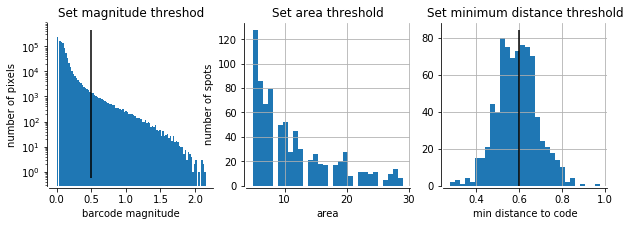

In [12]:
plt.figure(figsize=(10,3))

plt.subplot(131)
plt.hist(mags, bins=100);
plt.yscale('log')
plt.xlabel('barcode magnitude')
plt.ylabel('number of pixels')
sns.despine(offset=2)
plt.vlines(magnitude_threshold, ymin=plt.gca().get_ylim()[0], ymax=plt.gca().get_ylim()[1])
plt.title('Set magnitude threshod')

plt.subplot(132)
spots_df['area'] = np.pi*spots_df.radius**2
spots_df.area.hist(bins=30);
plt.xlabel('area')
plt.ylabel('number of spots')
sns.despine(offset=2)
plt.title('Set area threshold')

plt.subplot(133)
spots_df.distance.hist(bins=30)
plt.xlabel('min distance to code');
plt.vlines(min_dist, ymin=plt.gca().get_ylim()[0], ymax=plt.gca().get_ylim()[1])
sns.despine(offset=2)
plt.title('Set minimum distance threshold');

In [13]:
distance_threshold = min_dist

psd = DetectPixels.PixelSpotDecoder(
    codebook=experiment.codebook,
    metric='euclidean',
    distance_threshold=distance_threshold,
    magnitude_threshold=magnitude_threshold,
    min_area=area_threshold[0],
    max_area=area_threshold[1]
)

spot_intensities, results = psd.run(filtered_imgs)
spot_intensities = IntensityTable(spot_intensities.where(spot_intensities[Features.PASSES_THRESHOLDS], drop=True))

100%|██████████| 2167/2167 [00:02<00:00, 747.37it/s]


Here, we:

1. Pick a rolony that was succesfully decoded to a gene.
2. Pull out the average pixel trace for that rolony
3. Plot that pixel trace against the barcode of that gene

In order to assess, visually, how close decoded barcodes match their targets

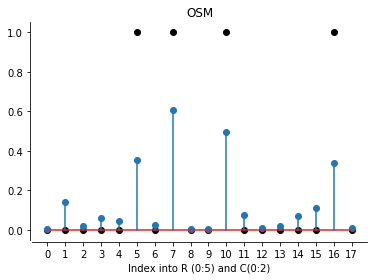

In [14]:
# reshape the spot intensity table into a RxC barcode vector
pixel_traces = spot_intensities.stack(traces=(Axes.ROUND.value, Axes.CH.value))

# extract dataframe from spot intensity table for indexing purposes
pixel_traces_df = pixel_traces.to_features_dataframe()
pixel_traces_df['area'] = np.pi*pixel_traces_df.radius**2

# pick index of a barcode that was read and decoded from the ImageStack
ind = 4

# get the the corresponding gene this barcode was decoded to
gene = pixel_traces_df.loc[ind].target

# query the codebook for the actual barcode corresponding to this gene
real_barcode = experiment.codebook[experiment.codebook.target==gene].stack(traces=(Axes.ROUND.value, Axes.CH.value)).values[0]
read_out_barcode = pixel_traces[ind,:]

plt.plot(real_barcode, 'ok')
plt.stem(read_out_barcode)
sns.despine(offset=2)
plt.xticks(range(18))
plt.title(gene)
plt.xlabel('Index into R (0:5) and C(0:2)');